# Importing Libraries

In [93]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder ,MinMaxScaler
from sklearn.pipeline import Pipeline ,make_pipeline 
from sklearn.compose import ColumnTransformer ,make_column_transformer
from sklearn.linear_model import LinearRegression ,LogisticRegression
from sklearn.tree import DecisionTreeRegressor ,DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier, BaggingClassifier, AdaBoostClassifier, VotingRegressor, \
                            GradientBoostingClassifier, RandomForestClassifier, RandomForestRegressor, GradientBoostingRegressor

from sklearn.neighbors import KNeighborsClassifier , KNeighborsRegressor
from sklearn.svm import SVC,SVR
from sklearn.metrics import r2_score ,accuracy_score ,f1_score,classification_report ,confusion_matrix
import joblib
import sklearn


# Load Data & EDA

In [94]:
df = pd.read_csv('card_transdata.csv')
df.head()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
0,57.877857,0.311140,1.945940,1.0,1.0,0.0,0.0,0.0
1,10.829943,0.175592,1.294219,1.0,0.0,0.0,0.0,0.0
2,5.091079,0.805153,0.427715,1.0,0.0,0.0,1.0,0.0
3,2.247564,5.600044,0.362663,1.0,1.0,0.0,1.0,0.0
4,44.190936,0.566486,2.222767,1.0,1.0,0.0,1.0,0.0


In [95]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 8 columns):
 #   Column                          Non-Null Count    Dtype  
---  ------                          --------------    -----  
 0   distance_from_home              1000000 non-null  float64
 1   distance_from_last_transaction  1000000 non-null  float64
 2   ratio_to_median_purchase_price  1000000 non-null  float64
 3   repeat_retailer                 1000000 non-null  float64
 4   used_chip                       1000000 non-null  float64
 5   used_pin_number                 1000000 non-null  float64
 6   online_order                    1000000 non-null  float64
 7   fraud                           1000000 non-null  float64
dtypes: float64(8)
memory usage: 61.0 MB


In [96]:
df.isnull().mean()*100

distance_from_home                0.0
distance_from_last_transaction    0.0
ratio_to_median_purchase_price    0.0
repeat_retailer                   0.0
used_chip                         0.0
used_pin_number                   0.0
online_order                      0.0
fraud                             0.0
dtype: float64

In [97]:
df.duplicated().sum()

np.int64(0)

In [98]:
df.describe()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
count,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000
mean,26.628792,5.036519,1.824182,0.881536,0.350399,0.100608,0.650552,0.087403
std,65.390784,25.843093,2.799589,0.323157,0.477095,0.300809,0.476796,0.282425
min,0.004874,0.000118,0.004399,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.878008,0.296671,0.475673,1.000000,0.000000,0.000000,0.000000,0.000000
50%,9.967760,0.998650,0.997717,1.000000,0.000000,0.000000,1.000000,0.000000
75%,25.743985,3.355748,2.096370,1.000000,1.000000,0.000000,1.000000,0.000000
max,10632.723672,11851.104565,267.802942,1.000000,1.000000,1.000000,1.000000,1.000000


Many outliers in:  
- Distance from home  
- Distance from last transaction  
- Ratio to median purchase price  

*We need to handle this*


In [99]:
df.nunique()

distance_from_home                1000000
distance_from_last_transaction    1000000
ratio_to_median_purchase_price    1000000
repeat_retailer                         2
used_chip                               2
used_pin_number                         2
online_order                            2
fraud                                   2
dtype: int64

In [100]:
df[['repeat_retailer','used_chip','used_pin_number','online_order','fraud']] =df[['repeat_retailer','used_chip','used_pin_number','online_order','fraud']].astype('int64')

In [101]:
df.dtypes

distance_from_home                float64
distance_from_last_transaction    float64
ratio_to_median_purchase_price    float64
repeat_retailer                     int64
used_chip                           int64
used_pin_number                     int64
online_order                        int64
fraud                               int64
dtype: object

## Univariate Analysis 

In [102]:
num_feat =df.select_dtypes(include='float64').columns
cat_feat = df.select_dtypes(include='int64').columns

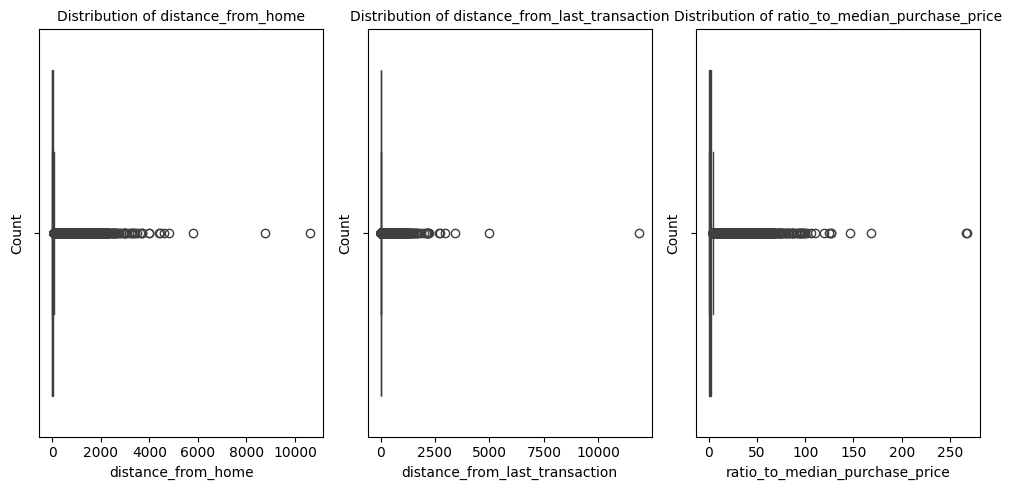

In [103]:
plt.figure(figsize=(10,5))

for i,col in enumerate(num_feat,1):
  plt.subplot(1,3,i)
  sns.boxplot(x=col , data=df )
  plt.title(f"Distribution of {col}", fontsize=10 )
  plt.xlabel(col)
  plt.ylabel('Count')

plt.tight_layout()
plt.show()

## Remove outliers

In [104]:
def remove_outliers_iqr(df, columns):
    df_clean = df.copy()
    
    for col in columns:
        Q1 = df_clean[col].quantile(0.25)
        Q3 = df_clean[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        df_clean = df_clean[(df_clean[col] >= lower_bound) & (df_clean[col] <= upper_bound)]
    
    return df_clean


In [105]:
df_clean=remove_outliers_iqr(df,num_feat)

In [106]:
print (f'data before remove outliers {df.shape}')
print (f'data after remove outliers {df_clean.shape}')


data before remove outliers (1000000, 8)
data after remove outliers (718686, 8)


In [107]:
df_clean.fraud.value_counts(normalize=True)*100

fraud
0    98.748828
1     1.251172
Name: proportion, dtype: float64

- We lost  a lot of data 

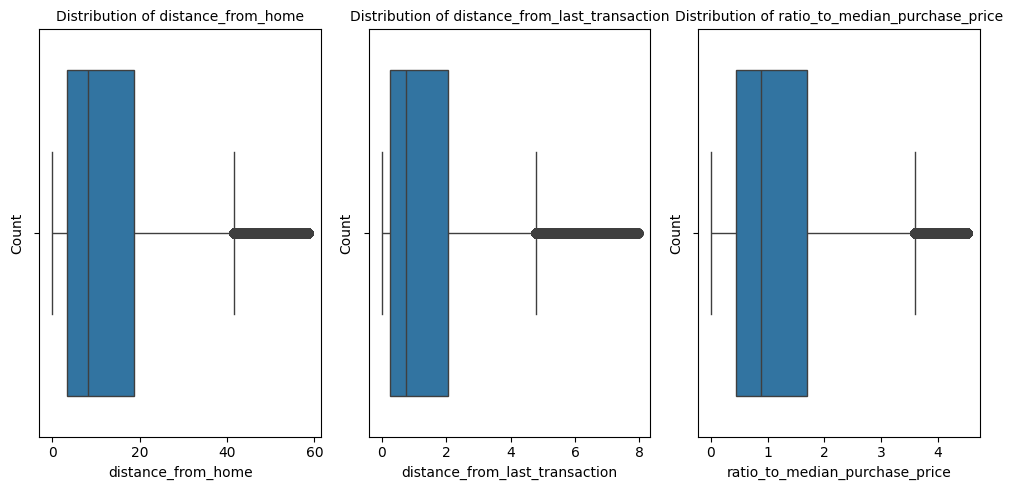

In [108]:
plt.figure(figsize=(10,5))

for i,col in enumerate(num_feat,1):
  plt.subplot(1,3,i)
  sns.boxplot(x=col , data=df_clean )
  plt.title(f"Distribution of {col}", fontsize=10 )
  plt.xlabel(col)
  plt.ylabel('Count')

plt.tight_layout()
plt.show()

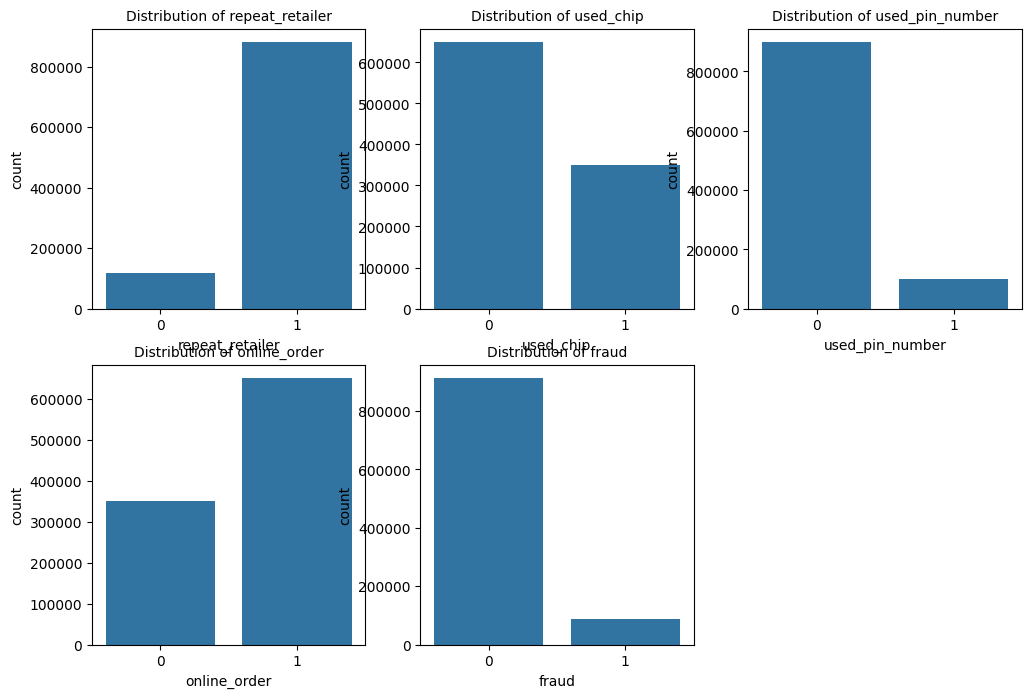

In [109]:
plt.figure(figsize=(12,8))
for i , col in enumerate(cat_feat , 1):
  plt.subplot(2,3,i)
  sns.countplot(x=col,data=df)
  plt.title(f"Distribution of {col}", fontsize=10 )
  
plt.show()

- Most transactions were made with **repeat retailers**.  
- The majority of transactions **did not use a chip or PIN number**.  
- Around **two-thirds of the transactions were online**.  
- The proportion of **fraudulent transactions is very low**, showing a clear **class imbalance**.  



## Bivariate Analysis

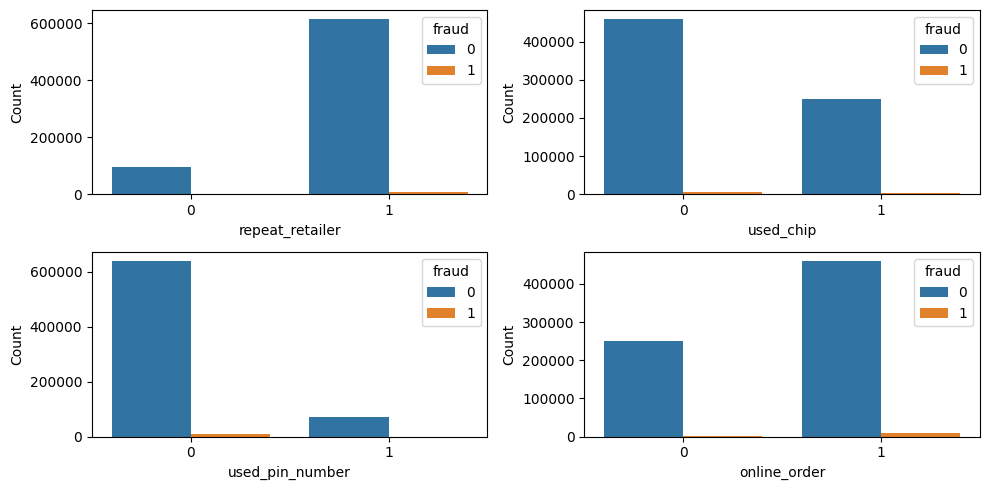

In [110]:
plt.figure(figsize=(10,5))

for i,col in enumerate(cat_feat.drop('fraud'),1):
  plt.subplot(2,2,i)
  sns.countplot(x=col , data=df_clean , hue='fraud')
  plt.xlabel(col)
  plt.ylabel('Count')

plt.tight_layout()
plt.show()

- **repeat_retailer = 0** → Higher fraud risk (new retailers).  
- **used_chip = 0** → Higher fraud risk (no chip used).  
- **used_pin_number = 0** → Higher fraud risk (no PIN verification).  
- **online_order = 1** → Higher fraud risk (online transactions).  



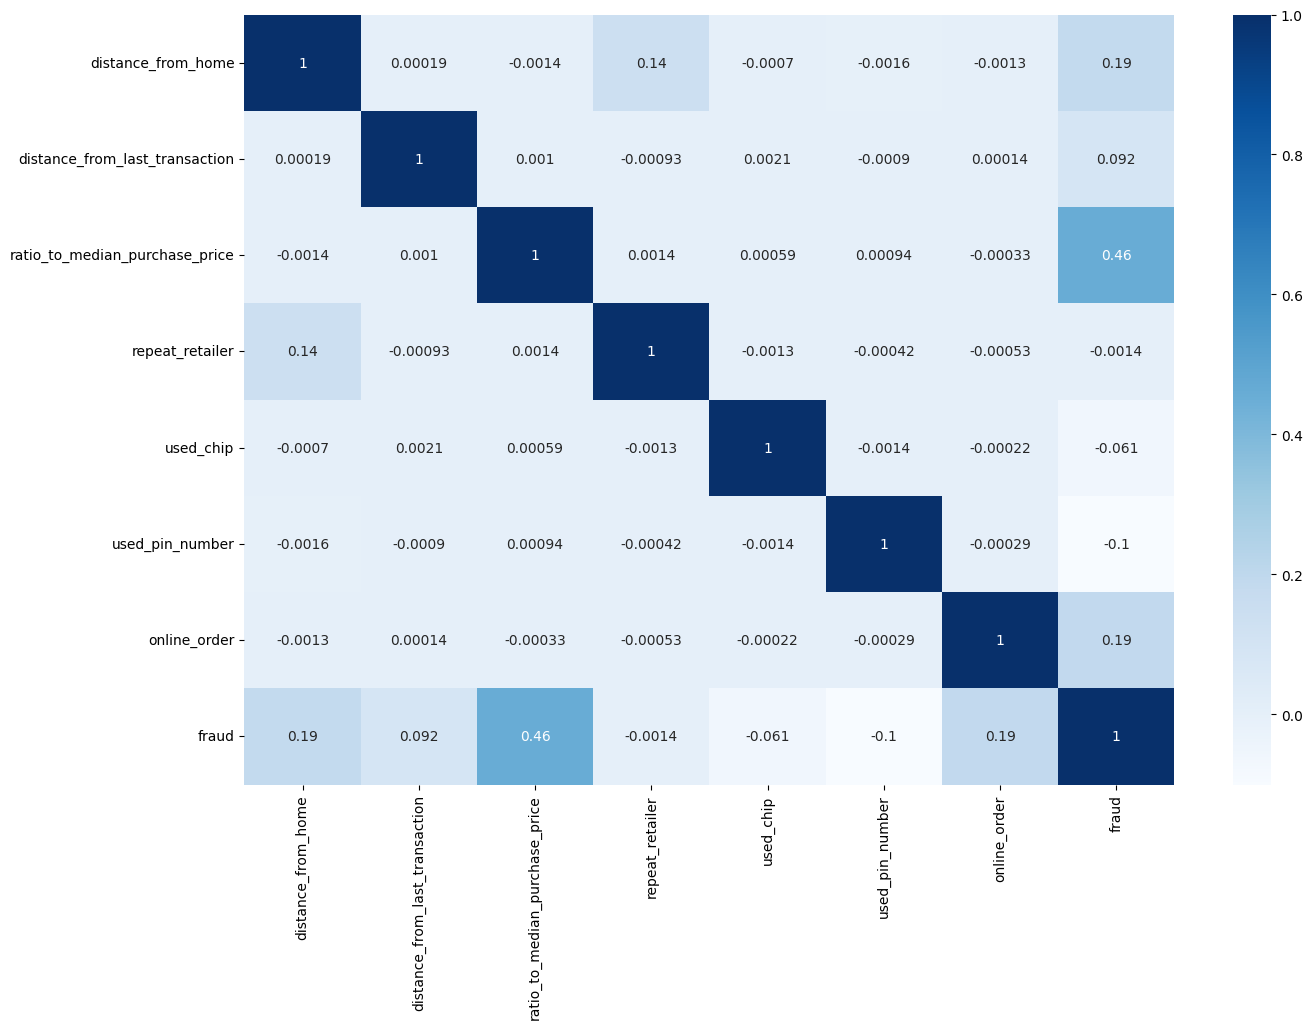

In [111]:
plt.figure(figsize=(15,10))
sns.heatmap(df.corr(),cmap='Blues',annot=True);

In [112]:

correlations = df.corr(numeric_only=True)['fraud'].apply(lambda x: abs(x)).sort_values(ascending=False)
correlations


fraud                             1.000000
ratio_to_median_purchase_price    0.462305
online_order                      0.191973
distance_from_home                0.187571
used_pin_number                   0.100293
distance_from_last_transaction    0.091917
used_chip                         0.060975
repeat_retailer                   0.001357
Name: fraud, dtype: float64

# Modeling


In [113]:
def pred_report(model,X_train,X_test,y_train,y_test,color='Blues', model_name='Model'):

  y_pred_train =model.predict(X_train)
  acc_train = accuracy_score(y_train,y_pred_train)
  print(f"🔹 {model_name} Train Accuracy: {acc_train:.4f}\n")
  
  y_pred_test = model.predict(X_test)
  acc_test = accuracy_score( y_test,y_pred_test)
  print(f"🔹 {model_name} Test Accuracy: {acc_test:.4f}\n")

  

  print(" Classification Report:")
  print(classification_report(y_test, y_pred_test))
  
  cm = confusion_matrix(y_test, y_pred_test)
  plt.figure(figsize=(4, 3))
  sns.heatmap(cm, annot=True, fmt='d', cmap=color, cbar=False)
  plt.title(f'{model_name} - Confusion Matrix')
  plt.xlabel('Predicted')
  plt.ylabel('Actual')
  plt.show()


In [114]:
def model_tunning(model, X_train, y_train, params, scoring='f1', cv=5):

    grid_search = GridSearchCV(
        estimator=model,
        param_grid=params,
        cv=cv,
        scoring=scoring,
        n_jobs=-1,
        verbose=2
    )
    
    grid_search.fit(X_train, y_train)
    
    print(" Best Parameters:", grid_search.best_params_)
    print(f" Mean cross-validated {scoring} score of the best estimator: {grid_search.best_score_:.4f}")
    
    return grid_search.best_estimator_


In [115]:
features = df.columns.drop(['fraud'])
target = 'fraud'

X = df[features]
y = df[target]


In [116]:
X_train,X_test,y_train ,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

X_train.shape , X_test.shape , y_train.shape,y_test.shape

((800000, 7), (200000, 7), (800000,), (200000,))

In [117]:
X_train['high_price_no_pin'] = (X_train['ratio_to_median_purchase_price'] > 2) & (X_train['used_pin_number'] == 0)
X_test['high_price_no_pin'] = (X_test['ratio_to_median_purchase_price'] > 2) & (X_test['used_pin_number'] == 0)

In [118]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

##  Logistic Regression

In [136]:
log_re = LogisticRegression(max_iter=1000,C=0.1,class_weight='balanced',solver='lbfgs')
log_re.fit(X_train,y_train)



LogisticRegression(C=0.1, class_weight='balanced', max_iter=1000)

🔹 Logistic Reg Train Accuracy: 0.9259

🔹 Logistic Reg Test Accuracy: 0.9263

 Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.92      0.96    182557
           1       0.54      0.95      0.69     17443

    accuracy                           0.93    200000
   macro avg       0.77      0.94      0.83    200000
weighted avg       0.96      0.93      0.93    200000



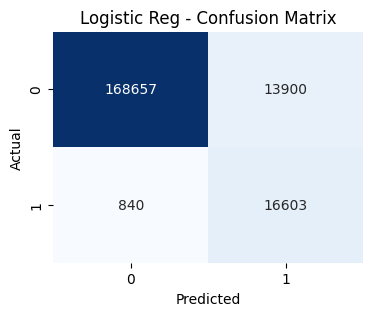

In [137]:
pred_report(log_re,X_train,X_test,y_train,y_test,model_name='Logistic Reg')

## DT

In [145]:
dt_model = DecisionTreeClassifier(
    criterion='gini',      
    max_depth=None,         
    random_state=42,
    class_weight='balanced' 
)

dt_model.fit(X_train, y_train)


DecisionTreeClassifier(class_weight='balanced', random_state=42)

🔹 DT Train Accuracy: 1.0000

🔹 DT Test Accuracy: 1.0000

 Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    182557
           1       1.00      1.00      1.00     17443

    accuracy                           1.00    200000
   macro avg       1.00      1.00      1.00    200000
weighted avg       1.00      1.00      1.00    200000



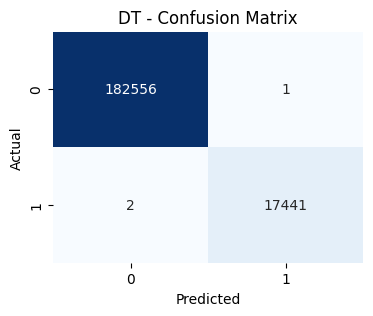

In [146]:
pred_report(dt_model,X_train,X_test,y_train,y_test,model_name='DT')

##  Random Forest

In [124]:
model = RandomForestClassifier(
    n_estimators=100,
    class_weight='balanced',
    random_state=42
)
model.fit(X_train,y_train)

RandomForestClassifier(class_weight='balanced', random_state=42)

🔹 Random Forest Train Accuracy: 1.0000

🔹 Random Forest Test Accuracy: 1.0000

 Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    182557
           1       1.00      1.00      1.00     17443

    accuracy                           1.00    200000
   macro avg       1.00      1.00      1.00    200000
weighted avg       1.00      1.00      1.00    200000



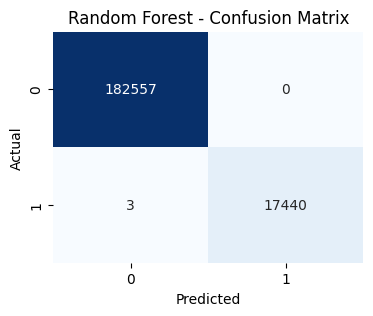

In [126]:
pred_report(model,X_train,X_test,y_train,y_test,model_name='Random Forest')

## XGBoost Classifier

In [143]:
from xgboost import XGBClassifier

xgb_clf = XGBClassifier(
    n_estimators=500,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    scale_pos_weight=len(y_train[y_train==0]) / len(y_train[y_train==1]),  # handle imbalance
    use_label_encoder=False,
    eval_metric='auc'
)

xgb_clf.fit(X_train, y_train)



XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=500,
              n_jobs=None, num_parallel_tree=None, ...)

🔹 Logistic Reg Train Accuracy: 0.9985

🔹 Logistic Reg Test Accuracy: 0.9979

 Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    182557
           1       0.98      1.00      0.99     17443

    accuracy                           1.00    200000
   macro avg       0.99      1.00      0.99    200000
weighted avg       1.00      1.00      1.00    200000



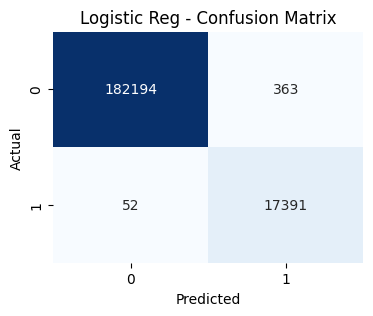

In [144]:
pred_report(xgb_clf,X_train,X_test,y_train,y_test,model_name='Logistic Reg')